In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
tf.__version__

'2.16.1'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-07-13 00:07:11.960138: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:07:12.500478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:07:12.500576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:07:12.503213: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:07:12.503294: I external/local_xla/xla/stream_executor

In [4]:
PATH = os.getcwd()
data_dir = PATH + "/data"
print(data_dir)

/mnt/d/major/data


In [5]:
batch_size = 32
img_height = 528
img_width = 652

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=batch_size,
)

Found 1600 files belonging to 8 classes.
Using 1280 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=batch_size,
)

Found 1600 files belonging to 8 classes.
Using 320 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Anwar Ratool', 'Chaunsa (Black)', 'Chaunsa (Summer Bahisht)', 'Chaunsa (White)', 'Dosehri', 'Fajri', 'Langra', 'Sindhri']


In [9]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         aax = plt.subplot(3, 3, i+1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis('off')
#         

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 528, 652, 3)
(32,)


In [11]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [12]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.BILINEAR, antialias=True)
    return image, label

In [13]:
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [2]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [3]:
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
len(list(base_model.layers))

187

In [4]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(8)

In [5]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [6]:
base_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

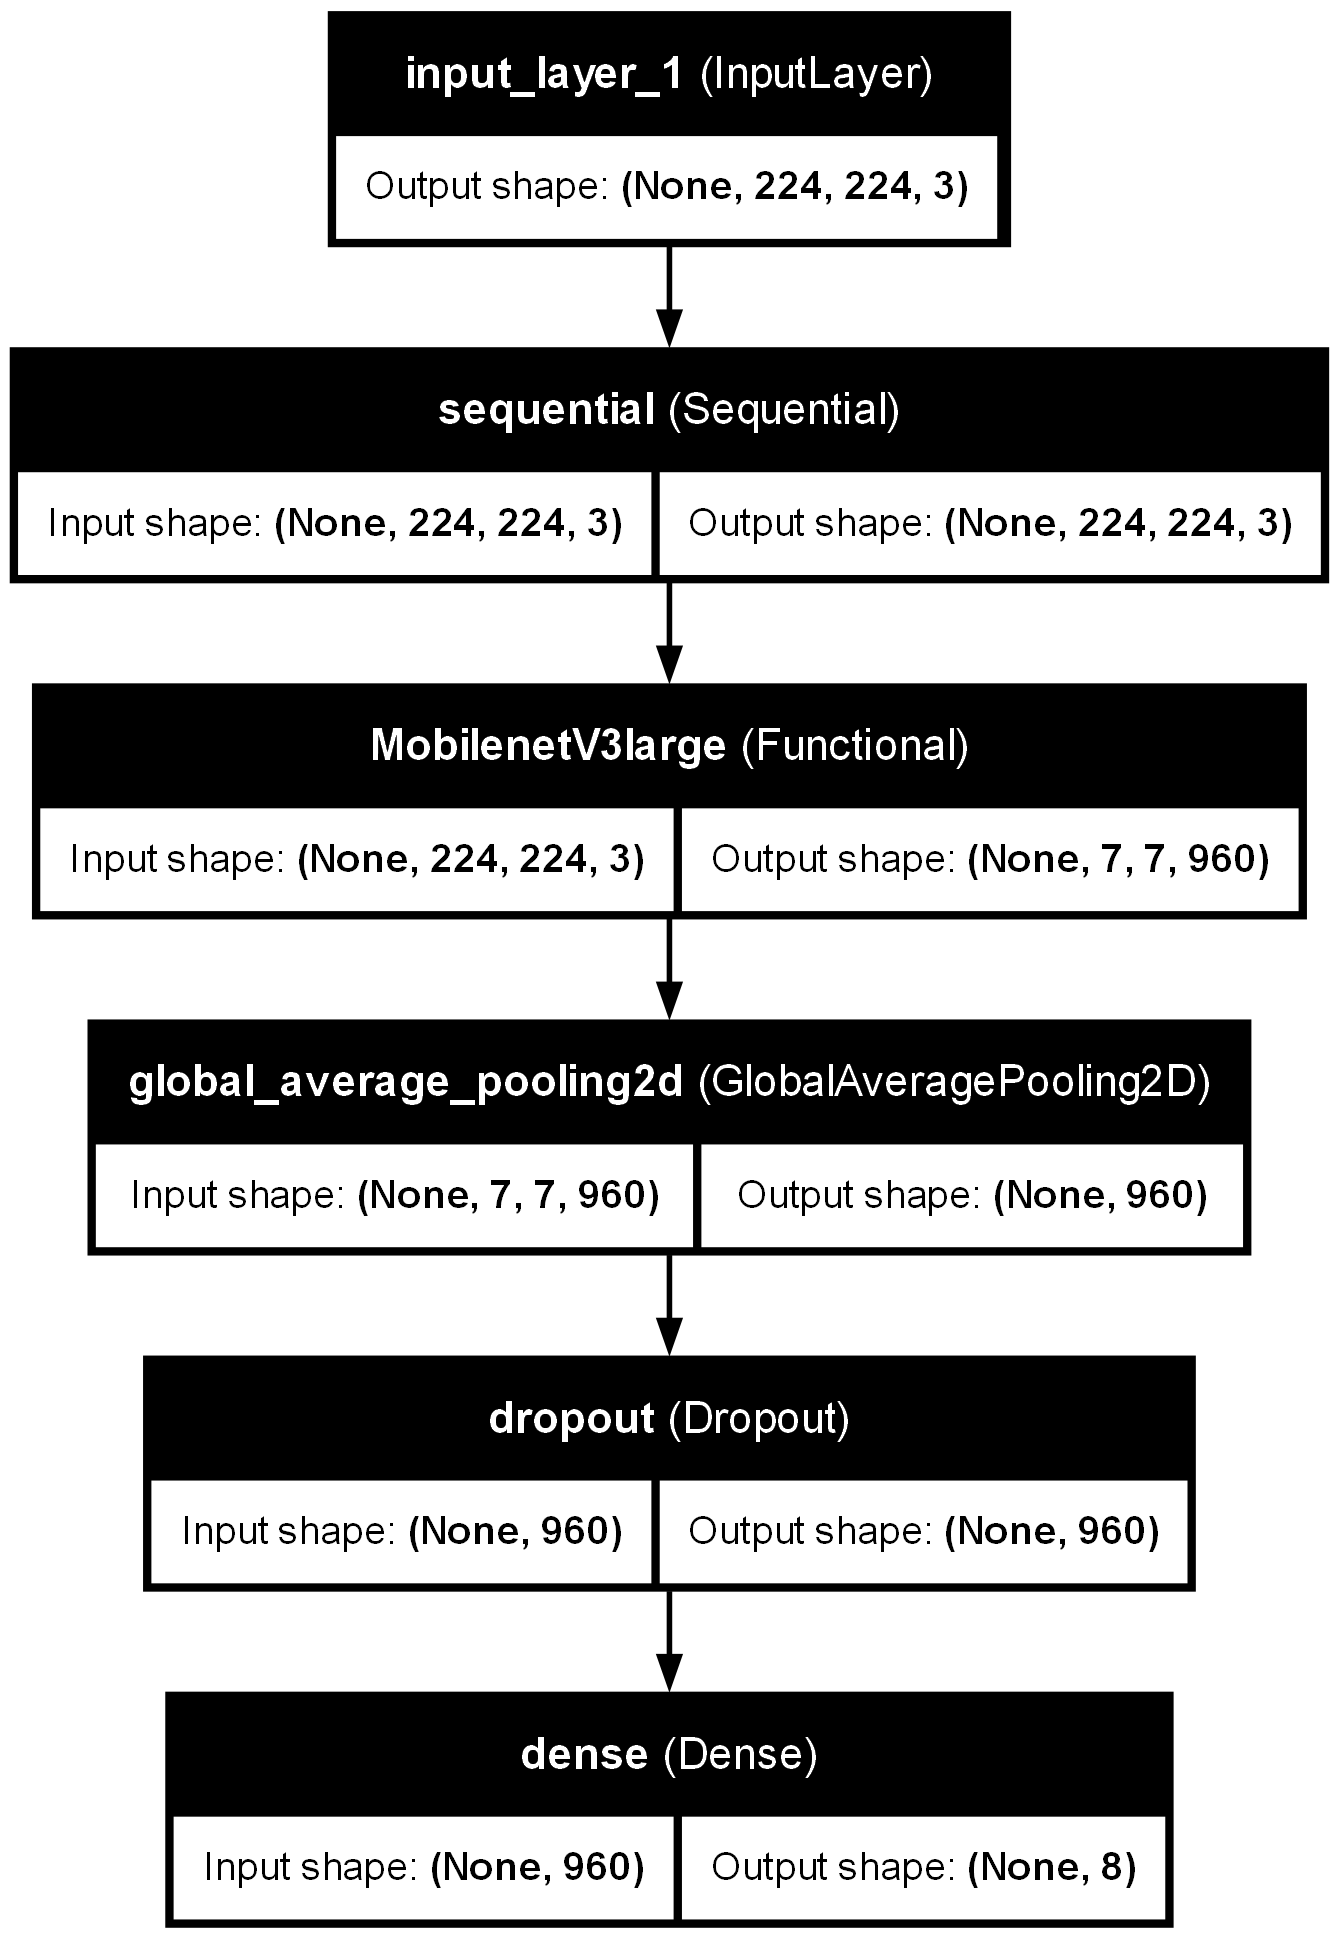

In [8]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [7]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 7,688 (30.03 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [115]:
initial_epochs = 10

In [116]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.2040 - loss: 2.0985 - val_accuracy: 0.6484 - val_loss: 1.3489
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.6020 - loss: 1.2318 - val_accuracy: 0.7773 - val_loss: 0.9858
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7348 - loss: 0.9083 - val_accuracy: 0.8047 - val_loss: 0.8145
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8249 - loss: 0.6998 - val_accuracy: 0.8164 - val_loss: 0.7022
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.8623 - loss: 0.5500 - val_accuracy: 0.8594 - val_loss: 0.6189
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8708 - loss: 0.5209 - val_accuracy: 0.8828 - val_loss: 0.5600
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8908 - loss: 0.4549 - val_accuracy: 0.8672 - val_loss: 0.5294
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8974 - loss: 0.4360 - val_accuracy: 0.8984 -

In [9]:
base_model.trainable = True

fine_tune_at = 180

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [10]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    metrics=['accuracy'],
)

In [11]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         7,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,004,040 (11.46 MB)

 Trainable params: 317,128 (1.21 MB)

 Non-trainable params: 2,686,912 (10.25 MB)

In [121]:
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,)

Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9824 - loss: 0.0926 - val_accuracy: 0.9141 - val_loss: 0.3043
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9878 - loss: 0.0823 - val_accuracy: 0.9102 - val_loss: 0.2913
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9816 - loss: 0.0921 - val_accuracy: 0.9180 - val_loss: 0.2772
Epoch 13/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9789 - loss: 0.0778 - val_accuracy: 0.9258 - val_loss: 0.2693
Epoch 14/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9830 - loss: 0.0818 - val_accuracy: 0.9453 - val_loss: 0.2434
Epoch 15/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9826 - loss: 0.0654 - val_accuracy: 0.9414 - val_loss: 0.2326
Epoch 16/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9833 - loss: 0.0627 - val_accuracy: 0.9453 - val_loss: 0.2281
Epoch 17/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9842 - loss: 0.0722 - val_accuracy

2024-07-13 00:36:34.505731: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 132194560 bytes after encountering the first element of size 132194560 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Predictions:
 [5 6 4 3 5 2 5 6 5 4 1 4 2 2 1 3 6 0 7 3 5 5 0 7 0 0 2 4 6 3 1 3]
Labels:
 [5 6 4 3 5 2 5 6 5 4 1 4 2 2 1 3 6 0 7 3 5 5 0 7 0 0 2 4 6 3 1 3]


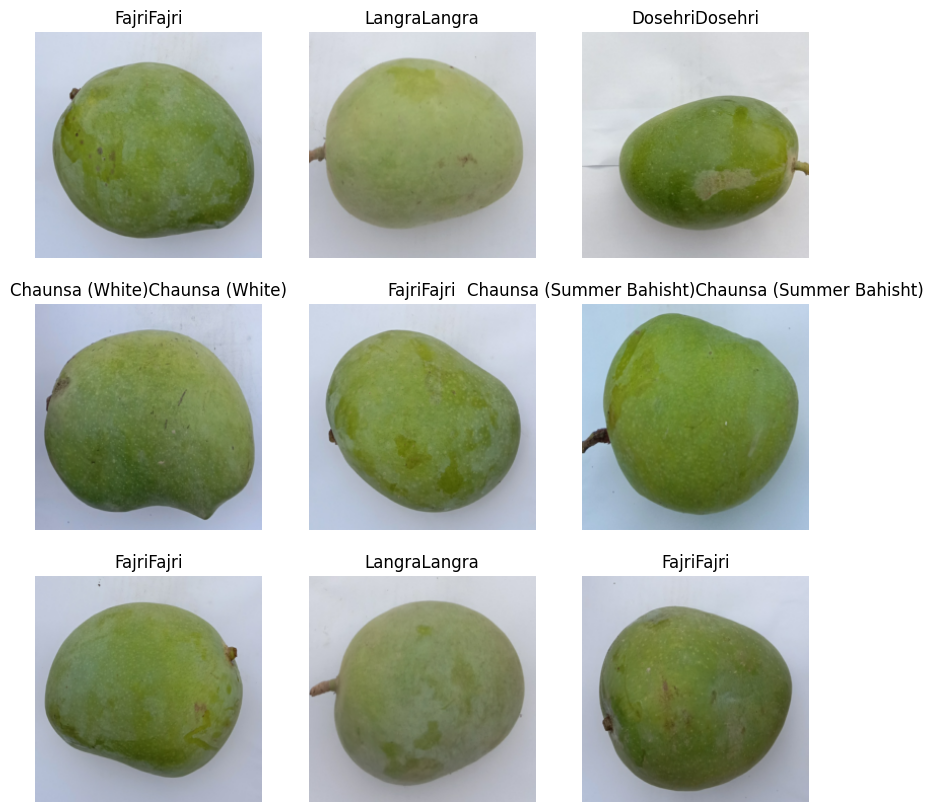

In [125]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)


predictions = tf.nn.softmax(predictions, axis=-1)
predicted_classes = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_classes.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_classes[i]] + class_names[label_batch[i]])
    plt.axis("off")

plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

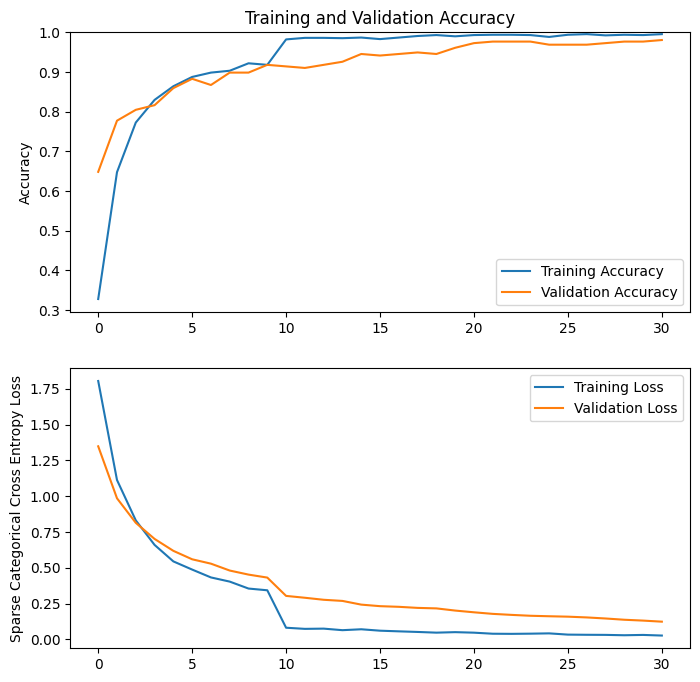

In [127]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim(min(plt.ylim()), 1)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Sparse Categorical Cross Entropy Loss')
plt.ylim([[0, 1.0]])
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.show()